# MATH 2071 Lab 4 - PDE boundary value problems

Matthew Ragoza

4/18/2022

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1 - Clothesline BVP

In this lab, we will consider methods for solving boundary value problems. Specifically we will focus on the scenario of a clothesline hanging between two different endpoints in which we would like to know the shape of the clothesline. The ODE that describes the system is:

$$
\begin{align}
    \frac{\partial}{\partial x} \left( K \frac{\partial u}{\partial x} \right) &= \rho g
\end{align}
$$

We can define the elastic modulus as a linear function of position $K(x) = 1 + \kappa x$ and obtain:

$$
\begin{align}
    ( K u' )' &= \rho g \\
    K u'' + K'u' &= \rho g \\
    (1 + \kappa x) u'' + \kappa u' &= \rho g
\end{align}
$$

Now we will solve this equation as a boundary value problem by specifying the physical parameters $\kappa$, $\rho$, and $g$ and the displacement values $u(x)$ at the endpoints.

Using finite difference approximations of the derivatives:

$$
\begin{align}
    u''_n &= \frac{u_{n+1} - 2 u_n + u_{n-1}}{\Delta x^2} \\
    u'_n &= \frac{u_{n+1} - u_{n-1}}{2 \Delta x}
\end{align}
$$

The ODE can be defined as follows:

$$
\begin{align}
    (1 + \kappa x_n) \frac{u_{n+1} - 2 u_n + u_{n-1}}{\Delta x^2} + \kappa \frac{u_{n+1} - u_{n-1}}{2 \Delta x} &= \rho g \\
    (1 + \kappa x_n) (u_{n+1} - 2 u_n + u_{n-1}) + \frac{\kappa \Delta x}{2} (u_{n+1} - u_{n-1}) &= \rho g \Delta x^2 \\
    \left(1 + \kappa x_n - \frac{\kappa \Delta x}{2} \right) u_{n-1} - 2(1 + \kappa x_n) u_n + \left(1 + \kappa x_n + \frac{\kappa \Delta x}{2}\right) u_{n+1} &= \rho g \Delta x^2
\end{align}
$$

Which can be represented as a linear system:

$$
\begin{align}
    \mathbf{A} &= \operatorname{tridiag}\left(1 + \kappa x_n - \frac{\kappa \Delta x}{2}, - 2(1 + \kappa x_n), 1 + \kappa x_n + \frac{\kappa \Delta x}{2} \right) \\
    \mathbf{A} \mathbf{u} &= \mathbf{b}
\end{align}
$$

Given boundary conditions, we can solve the linear system to obtain $u$ all at once.

We can begin by defining a uniform mesh on the interval $[0, 5]$ with $N_x = 6$ uniformly spaced grid points.

(array([0., 1., 2., 3., 4., 5.]), 1.0)

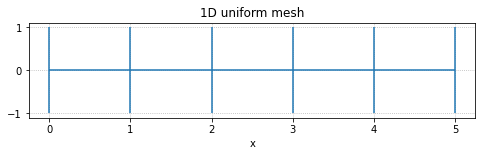

In [102]:
# define the mesh

def uniform_mesh_1d(x_min=0, x_max=5, n_x=6):
    dx = (x_max - x_min) / (n_x - 1)
    x = np.linspace(x_min, x_max, n_x)
    return x, dx

x, dx = uniform_mesh_1d()

fig, ax = plt.subplots(figsize=(8,1.75))
ax.hlines(0, x.min(), x.max())
ax.vlines(x, -1, 1)
ax.grid(True, linestyle=':')
ax.set_title('1D uniform mesh')
ax.set_xlabel('x')
x, dx

Then we can set up the linear system. The coefficients are stored in a tridiagonal $N_x \times N_x$ matrix and the righthand side is stored in an $N_x$ vector.

(array([[-2.   ,  1.025,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 1.025, -2.1  ,  1.075,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.075, -2.2  ,  1.125,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  1.125, -2.3  ,  1.175,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  1.175, -2.4  ,  1.225],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  1.225, -2.5  ]]),
 array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4]))

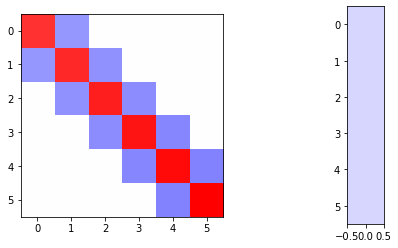

In [18]:
# define the linear system

def tridiag(a, b, c, n):
    return (
        a * (np.tri(n, k=-1) - np.tri(n, k=-2)) +
        b * np.eye(n) +
        c * (np.tri(n, k=1) - np.tri(n, k=0))
    )

def rope_system_1d(x, dx, kappa=0.05, rho_g=0.4):
    n_x = len(x)
    A = tridiag(
        1 + kappa * x + kappa * dx/2,
        -2 * (1 + kappa * x),
        1 + kappa * x - kappa * dx/2,
        n_x
    )
    b = np.full(n_x, rho_g * dx**2)
    return A, b

A, b = rope_system_1d(x, dx)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(-A, cmap='bwr', vmin=-np.abs(A).max(), vmax=np.abs(A).max())
axes[1].imshow(-b[:,np.newaxis], cmap='bwr', vmin=-np.abs(A).max(), vmax=np.abs(A).max())
A, b

In order to impose boundary conditions on the system, we can replace the first and last rows in the coefficient matrix with identity rows, and then put the boundary values in the corresponding position on the RHS.

(array([[ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 1.025, -2.1  ,  1.075,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.075, -2.2  ,  1.125,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  1.125, -2.3  ,  1.175,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  1.175, -2.4  ,  1.225],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ]]),
 array([1. , 0.4, 0.4, 0.4, 0.4, 1.5]))

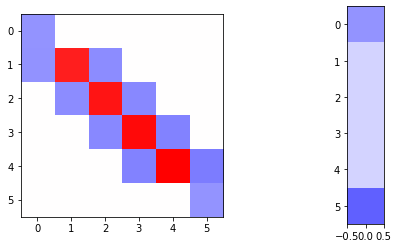

In [34]:
# define the boundary values

def set_boundary_1d(A, b, u_left=1.0, u_right=1.5):
    n_x, _ = A.shape
    assert A.shape == (n_x, n_x)
    assert b.shape == (n_x,)
    A, b = A.copy(), b.copy()
    A[0]  = (np.arange(n_x) == 0)
    A[-1] = (np.arange(n_x) == n_x - 1)
    b[0]  = u_left
    b[-1] = u_right
    return A, b

A, b = set_boundary_1d(A, b)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(-A, cmap='bwr', vmin=-np.abs(A).max(), vmax=np.abs(A).max())
axes[1].imshow(-b[:,np.newaxis], cmap='bwr', vmin=-np.abs(A).max(), vmax=np.abs(A).max())
A, b

Then we can put these pieces together to define and solve a boundary value problem for the 1-dimensional rope system.

array([1.        , 0.36361822, 0.12892862, 0.26022522, 0.72636026,
       1.5       ])

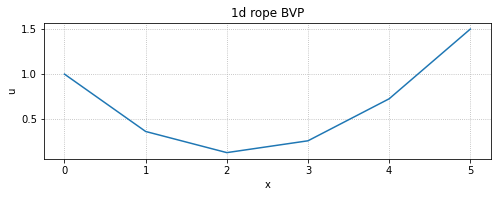

In [99]:
# solve the boundary value problem

def rope_bvp_six_points(u_left=1.0, u_right=1.5, kappa=0.05, rho_g=0.4):
    
    x, dx = uniform_mesh_1d(x_min=0, x_max=5, n_x=6)
    A, b = rope_system_1d(x, dx, kappa, rho_g)
    A, b = set_boundary_1d(A, b, u_left, u_right)
    return x, np.linalg.solve(A, b)

x, u = rope_bvp_six_points()

fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(x, u)
ax.grid(True, linestyle=':')
ax.set_title('1d rope BVP')
ax.set_xlabel('x')
ax.set_ylabel('u')
u

I created a function to plot the solution to the rope BVP on the six-point grid using different physical parameters. As expected, the default settings result in a rope-like curve hanging between the two endpoints positions. When `kappa` is increased to 0.75, the rope has less slack due to higher stiffness. When `rho_g` is set to zero, the rope becomes massless, so it has no slack at all due to there being no effect from gravity. Reversing the sign of `rho_g` also reverses the direction of gravity, so the rope hangs upward instead of downward. Changing the boundary conditions, for instance by increasing `u_right` to 5.0, shifts the height of the endpoints where the rope is attached.

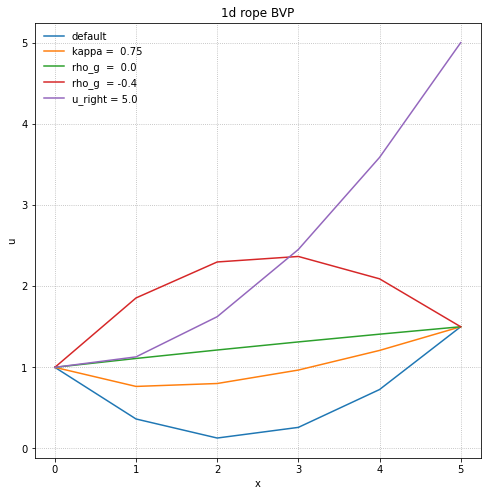

In [94]:
def exercise1():
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(*rope_bvp_six_points(), label='default')
    ax.plot(*rope_bvp_six_points(kappa=0.75), label=r'kappa =  0.75')
    ax.plot(*rope_bvp_six_points(rho_g=0.0), label='rho_g  =  0.0')
    ax.plot(*rope_bvp_six_points(rho_g=-0.4), label='rho_g  = -0.4')
    ax.plot(*rope_bvp_six_points(u_right=5.0), label='u_right = 5.0')
    ax.grid(True, linestyle=':')
    ax.set_title('1d rope BVP')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend(frameon=False)

exercise1()

## Exercise 2 - Uniform mesh resolution

We would now like to generalize the function to be able to solve the rope BVP on uniform meshes with different resolutions. Since I already implemented the problem using useful modular functions for defining the mesh, linear system, and boundary conditions, this is as easy as providing an additional argument to the rope BVP function specifying the number of grid points.

array([1.        , 0.36361822, 0.12892862, 0.26022522, 0.72636026,
       1.5       ])

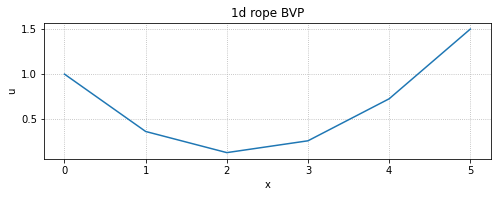

In [98]:
def rope_bvp(n_x=6, u_left=1.0, u_right=1.5, kappa=0.05, rho_g=0.4):
    x, dx = uniform_mesh_1d(x_min=0, x_max=5, n_x=n_x)
    A, b = rope_system_1d(x, dx, kappa, rho_g)
    A, b = set_boundary_1d(A, b, u_left, u_right)
    return x, np.linalg.solve(A, b)

x, u = rope_bvp()

fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(x, u)
ax.grid(True, linestyle=':')
ax.set_title('1d rope BVP')
ax.set_xlabel('x')
ax.set_ylabel('u')
u

The function produces the exact same solution to the BVP as before when using the default number of grid points (6). We can now investigate the effect of increasing the number of grid points to 11 or 121, which are plotted in the function below.

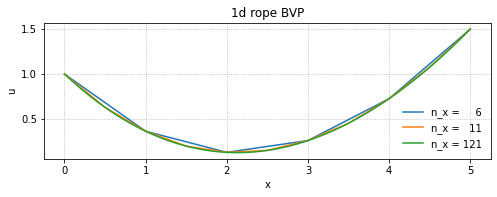

In [110]:
def exercise2():
    fig, ax = plt.subplots(figsize=(8,2.5))
    ax.plot(*rope_bvp(), label='n_x =     6')
    ax.plot(*rope_bvp(n_x=11), label=r'n_x =   11')
    ax.plot(*rope_bvp(n_x=121), label='n_x = 121')
    ax.grid(True, linestyle=':')
    ax.set_title('1d rope BVP')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend(frameon=False)
    
exercise2()

As the number of grid points increases, the solution to the BVP becomes smoother and more accurate.

## Exercise 3 - Lagrange polynomials

In this exercise, we will begin to implement a finite element method for solving the rope BVP by creating a function for evaluating Lagrange polynomials, which will serve as the basis functions for the solution.

I followed the instructions in the lab to define a function `phi(i, xn, xs)` that evaluates a Lagrange polynomial. I copied the code from the lab instructions and filled in the missing values from the definition of the Lagrange polynomial. The checks in the function make sure that we do not access an invalid array index at the boundary of the mesh when computing the function, which would result in an IndexError.

In [129]:
def phi(i, xn, xs):
    '''
    Lagrange polynomial basis function.
    
    Args:
        i: The index
        xn: The node vector
        xs: The sample points
    '''
    xs = np.atleast_1d(xs)
    zs = np.zeros_like(xs)
    if i % 2 == 1: # odd
        ks = np.nonzero((xn[i-1] <= xs) & (xs <= xn[i+1]))
        zs[ks] = (
            (xs[ks] - xn[i-1]) / (xn[i] - xn[i-1]) *
            (xs[ks] - xn[i+1]) / (xn[i] - xn[i+1])
        )
    else:
        if i > 0:
            ks = np.nonzero((xn[i-2] <= xs) & (xs <= xn[i]))
            zs[ks] = (
                (xs[ks] - xn[i-2]) / (xn[i] - xn[i-2]) *
                (xs[ks] - xn[i-1]) / (xn[i] - xn[i-1])
            )
        if i + 1 < len(xn):
            ks = np.nonzero((xn[i] <= xs) & (xs <= xn[i+2]))
            zs[ks] = (
                (xs[ks] - xn[i+1]) / (xn[i] - xn[i+1]) *
                (xs[ks] - xn[i+2]) / (xn[i] - xn[i+2])
            )
    
    return zs

Then, I implemented a function `exercise3()` that creates a 1D uniform mesh on the interval $[2,8]$ with 7 points. It also creates a sequence of 101 equally spaced sampled points on the same interval. Then it iterates over the mesh points and evaluates the Lagrange basis function for that node at each sample point. The resulting curves are plotted below.

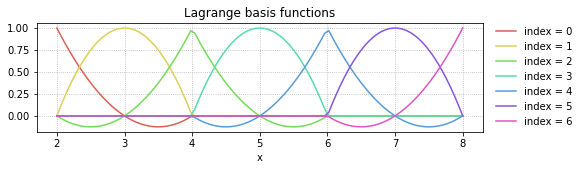

In [233]:
def exercise3(n_x=7):
    import seaborn as sns
    colors = sns.color_palette('hls', n_x)

    x, dx = uniform_mesh_1d(x_min=2, x_max=8, n_x=n_x)
    xs, _ = uniform_mesh_1d(x_min=2, x_max=8, n_x=101)

    fig, ax = plt.subplots(figsize=(8,2))
    for i in range(n_x):
        ax.plot(xs, phi(i, x, xs), color=colors[i], label=f'index = {i}')
    ax.grid(True, linestyle=':')
    ax.set_title('Lagrange basis functions')
    ax.set_xlabel('x')
    ax.legend(frameon=False, loc='upper left', bbox_to_anchor=[1.01,1.05])

exercise3()

## Exercise 4 - Lagrange polynomial derivatives

In order to use Lagrange polynomials in a finite element method, we also need to be able to evaluate their derivatives. In this exercise, we implement a function `phip(i, xn, xs)` which evaluates the derivative of a Lagrange polynomial at a set of sample points.

I implemented `phip` by copying and modyifying the code for `phi`, replacing the computations with the derivative of each segment of the piecewise function.

In [270]:
def phip(i, xn, xs):
    '''
    Lagrange basis function derivative.
    
    Args:
        i: The index
        xn: The node vector
        xs: The sample points
    '''
    xs = np.atleast_1d(xs)
    zps = np.zeros_like(xs)
    if i % 2 == 1: # odd
        ks = np.nonzero((xn[i-1] <= xs) & (xs <= xn[i+1]))
        zps[ks] = (
            -1.0 / (xn[i] - xn[i-1]) *
            (xs[ks] - xn[i+1]) / (xn[i] - xn[i+1]) - 
            (xs[ks] - xn[i-1]) / (xn[i] - xn[i-1]) *
            1.0 / (xn[i] - xn[i+1])
        )
    else:
        if i > 0:
            ks = np.nonzero((xn[i-2] <= xs) & (xs <= xn[i]))
            zps[ks] = (
                -1.0 / (xn[i] - xn[i-2]) *
                (xs[ks] - xn[i-1]) / (xn[i] - xn[i-1]) - 
                (xs[ks] - xn[i-2]) / (xn[i] - xn[i-2]) *
                1.0 / (xn[i] - xn[i-1])
            )
        if i + 1 < len(xn):
            ks = np.nonzero((xn[i] <= xs) & (xs <= xn[i+2]))
            zps[ks] = (
                -1.0 / (xn[i] - xn[i+1]) *
                (xs[ks] - xn[i+2]) / (xn[i] - xn[i+2]) - 
                (xs[ks] - xn[i+1]) / (xn[i] - xn[i+1]) *
                1.0 / (xn[i] - xn[i+2])
            )
    
    return zps

I created a function `exercise4()` which uses the same uniform mesh and sample points as the previous exercise. However, this time we evaluate and plot the derivatives of the Lagrange polynomials for each mesh point at the sample points.

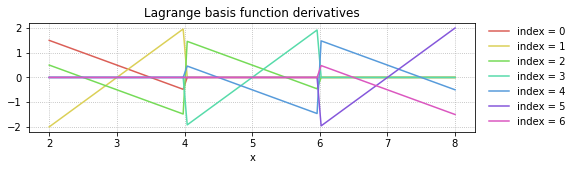

In [271]:
def exercise4(n_x=7):
    import seaborn as sns
    colors = sns.color_palette('hls', n_x)

    x, dx = uniform_mesh_1d(x_min=2, x_max=8, n_x=n_x)
    xs, _ = uniform_mesh_1d(x_min=2, x_max=8, n_x=101)

    fig, ax = plt.subplots(figsize=(8,2))
    for i in range(n_x):
        ax.plot(xs, phip(i, x, xs), color=colors[i], label=f'index = {i}')
    ax.grid(True, linestyle=':')
    ax.set_title('Lagrange basis function derivatives')
    ax.set_xlabel('x')
    ax.legend(frameon=False, loc='upper left', bbox_to_anchor=[1.01,1.05])

exercise4()

We notice that the plots of the Lagrange function derivatives appear discontinuous, which makes sense given that the Lagrange basis functions are defined as piecewise polynomials. We would expect discontinuities in the derivatives where the piecewise function changes intervals.

## Exercise 5 - Finite element method

The objective of this exercise is to implement another component of the finite element method, which is to create continuous, differentiable representations from a set of values defined on a discrete grid by taking linear combinations of grid values and the previously defined polynomial basis functions (and their derivatives).

I implemented FEM value and erivatives functions `fem_value` and `femp_value` below which return linear combinations of the basis functions (or their derivatives) and a set of mesh values on a set of sample points.

In [272]:
def fem_value(c, x_nodes, x_samples):

    n_nodes = len(x_nodes)
    n_samples = len(x_samples)
    
    y_samples = np.zeros(n_samples)
    for i in range(n_nodes):
        y_samples += c[i] * phi(i, x_nodes, x_samples)
    
    return y_samples

def femp_value(c, x_nodes, x_samples):

    n_nodes = len(x_nodes)
    n_samples = len(x_samples)
    
    yp_samples = np.zeros(n_samples)
    for i in range(n_nodes):
        yp_samples += c[i] * phip(i, x_nodes, x_samples)
    
    return yp_samples

I tested these functions in `exercise5` below, which first defines a mesh and then a set of values `c` defined on that mesh. Then, it samples and plots the linear combination of `c` and the polynomial basis functions (and their derivatives) at a set of sample points.

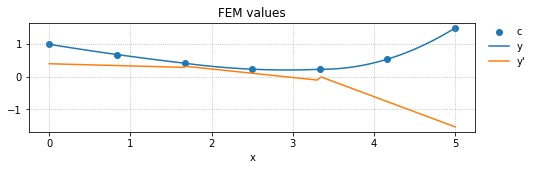

In [273]:
def exercise5():
    
    x, dx = uniform_mesh_1d(x_min=0, x_max=5, n_x=7)
    c = np.array([1.0, 0.68695865, 0.42029673, 0.23631118, 0.23352226, 0.54437828, 1.5])
    
    x_samples, _ = uniform_mesh_1d(x_min=0, x_max=5, n_x=101)
    y_samples = fem_value(c, x, x_samples)
    yp_samples = femp_value(c, x, x_samples)
    
    fig, ax = plt.subplots(figsize=(8,2))
    ax.scatter(x, c, label='c')
    ax.plot(x_samples, y_samples, label='y')
    ax.plot(x_samples, yp_samples, label='y\'')
    
    ax.grid(True, linestyle=':')
    ax.set_title('FEM values')
    ax.set_xlabel('x')
    ax.legend(frameon=False, loc='upper left', bbox_to_anchor=[1.01,1.05])
    
exercise5()

As seen in the plot above, this essentially performs polynomial interpolation between the values of `c`.

## Exercise 6 - Approximate integration

The purpose of this exercise is to implement a method for numerical integration called Gauss quadrature.

I implemented a function `gauss_quad(func, x_nodes, n_quad)` below which computes the integral of `func` on a mesh `x_nodes` using a Gauss quadrature rule consisting on `n_quad` points.

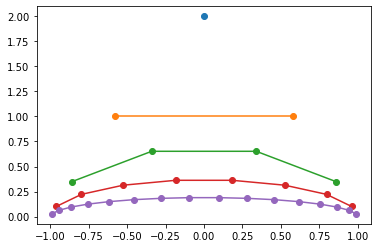

In [274]:
for i in [1, 2, 4, 8, 16]:
    x, w = np.polynomial.legendre.leggauss(i)
    plt.plot(x, w, marker='o')

In [275]:
def gauss_quad(func, x_nodes, n_quad):
    from numpy.polynomial.legendre import leggauss

    x_quad, w_quad = leggauss(n_quad)
    q = 0
    n_nodes = len(x_nodes)
    for i in range(n_nodes-1):
        x_ab = (x_nodes[i] * (1 - x_quad) + x_nodes[i+1] * (x_quad + 1)) / 2
        w_ab = (x_nodes[i+1] - x_nodes[i]) * w_quad / 2
        f_ab = func(x_ab)
        q_ab = np.sum(w_ab * f_ab)
        q += q_ab
    return q

To test the quadrature method, I wrote an integrable function `humps(x)` and its antiderivative `humps_anti(x)` which are plotted below on the interval $[0, 2]$.

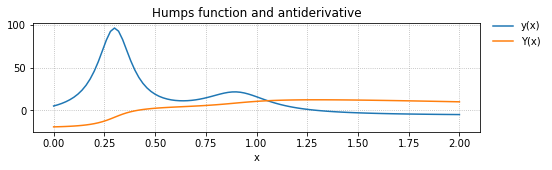

In [276]:
def humps(x):
    return 1/((x - 0.3)**2 + 0.01) + 1/((x-0.9)**2 + 0.04) - 6

def humps_anti(x):
    return 10*np.arctan(10*(x-0.3)) + 5*np.arctan(5*(x-0.9)) - 6*x

x, dx = uniform_mesh_1d(x_min=0, x_max=2, n_x=101)

fig, ax = plt.subplots(figsize=(8,2))
ax.plot(x, humps(x), label='y(x)')
ax.plot(x, humps_anti(x), label='Y(x)')
ax.grid(True, linestyle=':')
ax.set_title('Humps function and antiderivative')
ax.set_xlabel('x')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=[1.01,1.1])

In `exercise6` below, I first compute the exact definite integral of the `humps` functions on the interval using its antiderivative. Then, I perform Gaussian quadrature to numerically integrate the function using a range of different mesh resolutions and quadrature sizes. The resulting errors compared to the exact integral are collected into a data frame, plotted, and displayed in the cell output.

,n_nodes,n_quad,error
0,2,1,2.673786e+00
1,2,2,4.952372e+00
2,2,4,1.584655e+01
3,2,8,4.872175e+00
4,2,16,5.935253e-01
5,4,1,3.660358e+01
6,4,2,1.122339e+01
7,4,4,2.685494e+00
8,4,8,2.268688e-02
9,4,16,3.464723e-03


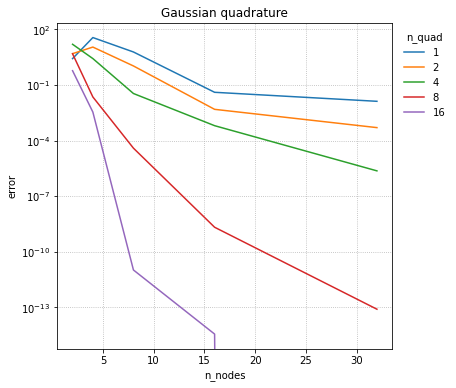

In [277]:
def exercise6():
    import pandas as pd
    exact = humps_anti(2) - humps_anti(0)
    data = []
    for n_nodes in [2, 4, 8, 16, 32]:
        x_nodes, dx = uniform_mesh_1d(x_min=0, x_max=2, n_x=n_nodes)
        for n_quad in [1, 2, 4, 8, 16]:
            q = gauss_quad(humps, x_nodes, n_quad)
            e = np.linalg.norm(q - exact)
            data.append((n_nodes, n_quad, e))
    
    data = pd.DataFrame(data, columns=['n_nodes', 'n_quad', 'error'])
    data['n_quad'] = data['n_quad'].astype(str) # treat as categorical
    
    fig, ax = plt.subplots(figsize=(6,6))
    sns.lineplot(data=data, x='n_nodes', y='error', hue='n_quad', ax=ax)
    ax.set_yscale('log')
    ax.grid(True, linestyle=':')
    ax.set_title('Gaussian quadrature')
    ax.legend(frameon=False, loc='upper left', bbox_to_anchor=[1.01,1.], title='n_quad')
    
    return data

exercise6()

We can see from the plot that increasing either the mesh resolution or the number of quadrature points increases the accuracy of the approximate integral.

## Exercise 7 - Integral of finite element function

In this exercise, we will compute the integrals involved in applying the finite element method to solve the rope BVP using the components we have built up so far.

In [278]:
def exercise7():
    
    x_nodes, dx = uniform_mesh_1d(x_min=0, x_max=5, n_x=7)
    
    kappa = 0.05
    rho_g = 0.4

    c = np.array([1.0, 0.68695865, 0.42029673, 0.23631118, 0.23352226, 0.54437828, 1.5])
    
    n_quad = 3
    
    int_A1 = gauss_quad(lambda x: -(1 + kappa*x) * phip(3, x_nodes, x) * phip(2, x_nodes, x), x_nodes, n_quad)
    int_A2 = gauss_quad(lambda x: kappa * phip(3, x_nodes, x) * phi(2, x_nodes, x), x_nodes, n_quad)
    int_b = gauss_quad(lambda x: rho_g * phi(2, x_nodes, x), x_nodes, n_quad)
    
    return int_A1, int_A2, int_b

exercise7()

(1.766666666666668, -0.03333333333333335, 0.22222222222222227)

We can verify from the output above the that method is producing the same values as reported in the lab instructions.

## Exercise 8 - Finite element method

We will now solve the rope BVP problem using the finite element method. The PDE is:

$$
\begin{align*}
    (1 + \kappa x) u'' + \kappa u' &= \rho g \\
\end{align*}
$$

We can rewrite it in terms of the finite element basis functions:

$$
\begin{align*}
    (1 + \kappa x) \sum_j c_j \phi_j'' + \kappa \sum_j c_j \phi_j' &= \rho g \\
\end{align*}
$$

Multiply through by $\phi_i$:

$$
\begin{align*}
    \phi_i (1 + \kappa x) \sum_j c_j \phi_j'' + \phi_i \kappa \sum_j c_j \phi_j' &= \phi_i \rho g \\
\end{align*}
$$

Integrate over the domain $\Omega$:

$$
\begin{align*}
    \int_{\Omega} \left( \phi_i (1 + \kappa x) \sum_j c_j \phi_j'' + \phi_i \kappa \sum_j c_j \phi_j' \right) dx &= \int_{\Omega} \phi_i \rho g dx \\
\end{align*}
$$

Apply integration by parts to get rid of $\phi''$ (boundary term is zero):

$$
\begin{align*}
    \int_{\Omega} \left( -\phi_i' (1 + \kappa x) \sum_j c_j \phi_j' + \phi_i \kappa \sum_j c_j \phi_j' \right) dx &= \int_{\Omega} \phi_i \rho g dx \\
\end{align*}
$$

Pull out the summation and the constants:

$$
\begin{align*}
    \sum_j \left(\int_{\Omega} -\phi_i' (1 + \kappa x) \phi_j' + \phi_i \kappa \phi_j' dx  \right) c_j &= \int_{\Omega} \phi_i \rho g dx \\
\end{align*}
$$

Which resolves into the ith equation of a linear system:

$$
\begin{align*}
    \mathbf{A} \mathbf{c} &= \mathbf{b} \\
\end{align*}
$$

We can therefore use Gauss quadrature to evaluate the necessary integrals to construct the matrix $\mathbf{A}$ and the righthand side $\mathbf{b}$, then solve the linear system to produce the coefficients $\mathbf{c}$ defining the solution to the PDE.

(7, 7)


array([1.        , 0.959415  , 0.91979   , 0.881125  , 0.84342001,
       0.80667501, 0.77089001, 0.73606501, 0.70220001, 0.66929501,
       0.63735002, 0.60636502, 0.57634002, 0.54727502, 0.51917002,
       0.49202502, 0.46584003, 0.44061503, 0.41635003, 0.39304503,
       0.37070003, 0.34931503, 0.32889003, 0.30942504, 0.29092004,
       0.27337504, 0.25679004, 0.24116504, 0.22650004, 0.21279505,
       0.20005005, 0.18826505, 0.17744005, 0.16757505, 0.15864412,
       0.15060096, 0.1434467 , 0.13718132, 0.13180483, 0.12731723,
       0.12371852, 0.1210087 , 0.11918776, 0.11825572, 0.11821256,
       0.11905829, 0.12079291, 0.12341643, 0.12692882, 0.13133011,
       0.13662029, 0.14279936, 0.14986731, 0.15782416, 0.16666989,
       0.17640451, 0.18702802, 0.19854042, 0.21094171, 0.22423189,
       0.23841095, 0.25347891, 0.26943575, 0.28628148, 0.30401611,
       0.32263962, 0.34215202, 0.36254584, 0.38377277, 0.40582729,
       0.42870939, 0.45241907, 0.47695635, 0.50232121, 0.52851

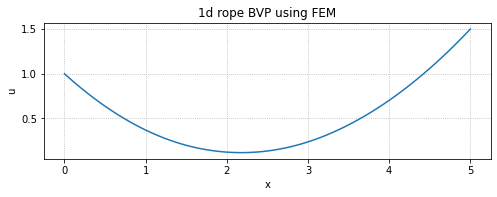

In [312]:
def exercise8(n_nodes=7, n_quad=3, u_left=1.0, u_right=1.5, n_samples=101):
    
    # define the mesh
    x_min = 0
    x_max = 5
    x_nodes, dx = uniform_mesh_1d(x_min, x_max, n_nodes)
    
    # define the problem data
    kappa = 0.05
    rho_g = 0.4
    
    # construct the linear system
    A = np.zeros((n_nodes, n_nodes))
    b = np.zeros(n_nodes)
    
    for i in range(n_nodes):
        
        if i == 0: # left boundary
            A[i,i] = 1.0
            b[i] = u_left
        
        elif i+1 == n_nodes: # right boundary
            A[i,i] = 1.0
            b[i] = u_right
    
        else: # internal node
            b[i] = gauss_quad(lambda x: phi(i, x_nodes, x) * rho_g, x_nodes, n_quad)
            for j in range(n_nodes):
                 A[i,j] = gauss_quad(lambda x: \
                    phip(i, x_nodes, x) * (-1 - kappa*x) * phip(j, x_nodes, x) + \
                    phi(i, x_nodes, x) * kappa * phip(j, x_nodes, x),
                    x_nodes, n_quad
                )
                    
    print(A.shape)
    
    # solve the linear system
    c = np.linalg.solve(A, b)
    
    # compute a solution curve
    x, dx = uniform_mesh_1d(x_min, x_max, n_samples)
    u = fem_value(c, x_nodes, x)
    
    fig, ax = plt.subplots(figsize=(8,2.5))
    ax.plot(x, u)
    ax.grid(True, linestyle=':')
    ax.set_title('1d rope BVP using FEM')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    return u

exercise8()

I put all of this together into the function `exercise8` which sets up the rope BVP and solves it using the finite element method, as described above. The resulting plot shows a similar curve as the the one produce in `exercise1`, which used finite differences. However, the one from FEM is move smoother because it produces a continuous solution in terms of the polynomial basis functions. Therefore it allows sampling the solution curve at a higher resolution that the original mesh.

array([1.        , 0.44067707, 0.16472627, 0.15076105, 0.37972789,
       0.83457893, 1.5       ])

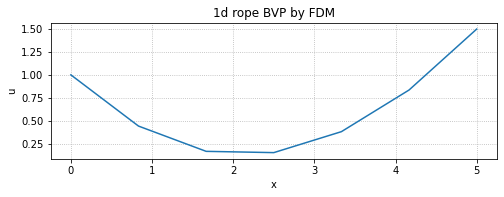

In [313]:
x, u = rope_bvp(n_x=7)

fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(x, u)
ax.grid(True, linestyle=':')
ax.set_title('1d rope BVP by FDM')
ax.set_xlabel('x')
ax.set_ylabel('u')
u

For reference, the curve for the finite difference method from `exercise1` is shown above using the same mesh resolution as the finite element method. The solution is only defined on the mesh points, so it appears much coarser than the one from the FEM method.

array([1.        , 0.95844953, 0.9179192 , 0.87840901, 0.83991896,
       0.80244905, 0.76599927, 0.73056964, 0.69616015, 0.6627708 ,
       0.63040158, 0.59905251, 0.56872358, 0.53941478, 0.51112613,
       0.48385761, 0.45760924, 0.432381  , 0.40817291, 0.38498495,
       0.36281714, 0.34166946, 0.32154192, 0.30243453, 0.28434727,
       0.26728015, 0.25123318, 0.23620634, 0.22219964, 0.20921308,
       0.19724666, 0.18630038, 0.17637424, 0.16746824, 0.15950337,
       0.15239781, 0.1461668 , 0.14081035, 0.13632846, 0.13272112,
       0.12998834, 0.12813011, 0.12714643, 0.12703732, 0.12780275,
       0.12944275, 0.1319573 , 0.1353464 , 0.13961006, 0.14474828,
       0.15076105, 0.15764837, 0.16541025, 0.17404669, 0.18355768,
       0.19394323, 0.20520334, 0.21733799, 0.23034721, 0.24423098,
       0.2589893 , 0.27462218, 0.29112962, 0.30851161, 0.32676816,
       0.34589926, 0.36590492, 0.38676132, 0.40836699, 0.43073072,
       0.4538525 , 0.47773232, 0.5023702 , 0.52776614, 0.55392

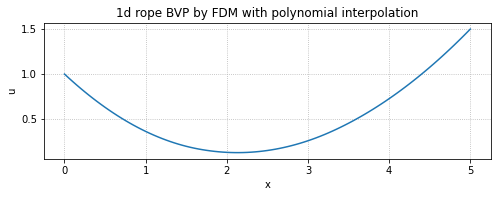

In [314]:
x_nodes, c = rope_bvp(n_x=7)
x, dx = uniform_mesh_1d(0, 5, 101)
u = fem_value(c, x_nodes, x)

fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(x, u)
ax.grid(True, linestyle=':')
ax.set_title('1d rope BVP by FDM with polynomial interpolation')
ax.set_xlabel('x')
ax.set_ylabel('u')
u

However, it is possible to obtain a similarly smooth curve from the finite difference method by using the same polynomial basis functions as were used in FEM. We can use the basis functions to interpolate between the points produce by the finite element method, resulting in a continuous curve.

## Exercise 9 - A new boundary value problem

In this exercise we will investigate a new boundary value problem based on the following PDE:

$$
    y'' + y' + y = x + 1
$$

The exact solution takes the following form, with $\omega = \sqrt{3} / 2$:

$$
    y(x) = x - e^{-(x-1)/2} \sin(\omega x) \csc(\omega)
$$

The FEM derivation:

$$
\begin{align*}
    \sum_j c_j \phi_j'' + \sum_j c_j \phi_j' + \sum_j c_j \phi_j &= x + 1 \\
    \phi_i \sum_j c_j \phi_j'' + \phi_i \sum_j c_j \phi_j' + \phi_i \sum_j c_j \phi_j &= \phi_i (x + 1) \\
    \int_{\Omega} \left( \phi_i \sum_j c_j \phi_j'' + \phi_i \sum_j c_j \phi_j' + \phi_i \sum_j c_j \phi_j \right) dx &= \int_{\Omega} \phi_i (x + 1) dx \\
    \int_{\Omega} \left( -\phi_i' \sum_j c_j \phi_j' + \phi_i \sum_j c_j \phi_j' + \phi_i \sum_j c_j \phi_j \right) dx &= \int_{\Omega} \phi_i (x + 1) dx \\
    \sum_j \left( \int_{\Omega} -\phi_i' \phi_j' + \phi_i \phi_j' + \phi_i \phi_j dx \right) c_j &= \int_{\Omega} \phi_i (x + 1) dx \\
    \mathbf{A} \mathbf{c} &= \mathbf{b} \\
\end{align*}
$$

We can now implement this and solve the new BVP using the finite element method.

(9, 9)
maximum absolute error = 0.02975009


array([ 1.18276003e-16, -2.37469343e-02, -4.64195987e-02, -6.80179929e-02,
       -8.85421171e-02, -1.07991971e-01, -1.26367555e-01, -1.43464268e-01,
       -1.58586100e-01, -1.71682337e-01, -1.82752979e-01, -1.91798026e-01,
       -1.98817477e-01, -2.03713535e-01, -2.05677370e-01, -2.04537167e-01,
       -2.00292928e-01, -1.92944651e-01, -1.82492338e-01, -1.68913576e-01,
       -1.51435114e-01, -1.29687132e-01, -1.03669629e-01, -7.33826064e-02,
       -3.88260634e-02,  0.00000000e+00])

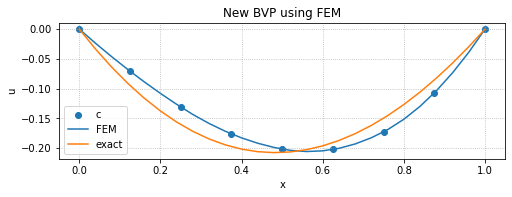

In [347]:
def exercise9(n_nodes=9, n_quad=3, u_left=0.0, u_right=0.0, n_samples=26):
    
    # define the mesh
    x_min = 0
    x_max = 1
    x_nodes, dx = uniform_mesh_1d(x_min, x_max, n_nodes)
    
    # construct the linear system
    A = np.zeros((n_nodes, n_nodes))
    b = np.zeros(n_nodes)
    
    for i in range(n_nodes):
        
        if i == 0: # left boundary
            A[i,i] = 1.0
            b[i] = u_left
        
        elif i+1 == n_nodes: # right boundary
            A[i,i] = 1.0
            b[i] = u_right
    
        else: # internal node
            b[i] = gauss_quad(lambda x: phi(i, x_nodes, x) * (x + 1), x_nodes, n_quad)
            for j in range(n_nodes):
                 A[i,j] = gauss_quad(lambda x: \
                    -phip(i, x_nodes, x) * phip(j, x_nodes, x) + \
                    phi(i, x_nodes, x) * phip(j, x_nodes, x) + \
                    phi(i, x_nodes, x) * phi(j, x_nodes, x),
                    x_nodes, n_quad
                )
                    
    print(A.shape)
    
    # solve the linear system
    c = np.linalg.solve(A, b)
    
    # compute a solution curve
    x, dx = uniform_mesh_1d(x_min, x_max, n_samples)
    u = fem_value(c, x_nodes, x)
    
    # get exact solution
    omega = np.sqrt(3) / 2
    u_exact = x - np.exp(-(x - 1)/ 2) * np.sin(omega * x) / np.sin(omega)
    
    fig, ax = plt.subplots(figsize=(8,2.5))
    ax.scatter(x_nodes, c, label='c')
    ax.plot(x, u, label='FEM')
    ax.plot(x, u_exact, label='exact')
    ax.grid(True, linestyle=':')
    ax.set_title('New BVP using FEM')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    
    # print error
    e = np.linalg.norm(u_exact - u, np.inf)
    print(f'maximum absolute error = {e:.8f}')
    
    return u

exercise9(n_nodes=9)

The plot above shows the FEM coefficients and polynomial interpolation in blue along with the exact solution to the BVP in orange. The maximum absolute error between the two is $0.0297$, which is higher than expected.

## Exercise 10

The goal of this exercise is to analyze the convergence rate of the FEM method with respect to the number of mesh nodes.

In [349]:
def exercise10(n_nodes=9, n_quad=3, u_left=0.0, u_right=0.0, n_samples=26):
    
    # define the mesh
    x_min = 0
    x_max = 1
    x_nodes, dx = uniform_mesh_1d(x_min, x_max, n_nodes)
    
    # construct the linear system
    A = np.zeros((n_nodes, n_nodes))
    b = np.zeros(n_nodes)
    
    for i in range(n_nodes):
        
        if i == 0: # left boundary
            A[i,i] = 1.0
            b[i] = u_left
        
        elif i+1 == n_nodes: # right boundary
            A[i,i] = 1.0
            b[i] = u_right
    
        else: # internal node
            b[i] = gauss_quad(lambda x: phi(i, x_nodes, x) * (x + 1), x_nodes, n_quad)
            for j in range(n_nodes):
                 A[i,j] = gauss_quad(lambda x: \
                    -phip(i, x_nodes, x) * phip(j, x_nodes, x) + \
                    phi(i, x_nodes, x) * phip(j, x_nodes, x) + \
                    phi(i, x_nodes, x) * phi(j, x_nodes, x),
                    x_nodes, n_quad
                )
                    
    print(A.shape)
    
    # solve the linear system
    c = np.linalg.solve(A, b)
    
    # compute a solution curve
    x, dx = uniform_mesh_1d(x_min, x_max, n_samples)
    u = fem_value(c, x_nodes, x)
    
    # get exact solution
    omega = np.sqrt(3) / 2
    u_exact = x - np.exp(-(x - 1)/ 2) * np.sin(omega * x) / np.sin(omega)
    
    # return error
    return np.linalg.norm(u_exact - u, np.inf)

e_prev = np.nan
for n_nodes in [3, 5, 9, 17, 33]:
    e = exercise10(n_nodes)
    r = e / e_prev
    e_prev = e
    print(f'error = {e:.8f}\trelative = {r:.8f}')

(3, 3)
error = 0.00668514	relative = nan
(5, 5)
error = 0.02902782	relative = 4.34213920
(9, 9)
error = 0.02975009	relative = 1.02488182
(17, 17)
error = 0.02967435	relative = 0.99745407
(33, 33)
error = 0.02965590	relative = 0.99937821


As we can see above, the error increases initially and then quickly plateues at 0.296, with a relative error of around 1.0 indicating no change. This is not what I expect to see, and makes me think that there is a bug in my code that I have not been able to find.